<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_icon_share.svg"
     alt="Cubes & Clouds Processing logo" width="00"
     style="width: 2500px; height:300px; float: center; margin-right: 10px;" />

# 3.4 Data Sharing
Science is much more impactful once it's shared. Therefore, we are going to learn how to 
open up our scientific output from a cloud platform, so that is openly available - and 
has the chance to make the impact it should.
- Load data
- ...


## Libraries

In [1]:
import json

import openeo
import numpy as np
import leafmap

import geopandas as gpd
import shapely
from shapely.geometry import Polygon

import rioxarray as rio
import xarray

Import utility functions

In [2]:
%run cubes_utilities.py

## Login

Connect to the copernicus dataspace ecosystem.

In [3]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/')

Authenticate login

In [4]:
conn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

Check if the login worked

In [5]:
conn.describe_account()

{'info': {'oidc_userinfo': {'email': 'rufaibalogun1@gmail.com',
   'email_verified': True,
   'family_name': 'Balogun',
   'given_name': 'Rufai Omowunmi',
   'name': 'Rufai Omowunmi Balogun',
   'preferred_username': 'rufaibalogun1@gmail.com',
   'sub': '06183cbc-84c8-4c6a-8a7d-cb18ba08cc8c'}},
 'name': 'Rufai Omowunmi Balogun',
 'user_id': '06183cbc-84c8-4c6a-8a7d-cb18ba08cc8c'}

## Select a Point of Interest
Start by selecting a center point of the area you would like to analyse from the map shown below

In [6]:
m = leafmap.Map(center=(46.497012, 11.356429), zoom=14)
m

Map(center=[46.497012, 11.356429], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [7]:
feat = m.draw_features
geom = feat[0]['geometry']['coordinates']

In [8]:
distance_km = 1
# Create a bounding box around the point
bbox = create_bounding_box(geom[0], geom[1], distance_km)
visualize_bbox(m, bbox)

## Recreate process graph

In [9]:
temporal_extent = ["2018-02-01", "2018-06-30"]
snow_map_4dcube = calculate_sca(conn, bbox, temporal_extent)
snow_map_4dcube

## Reduce dimension

In [10]:
snow_map_3dcube = snow_map_4dcube.reduce_dimension(reducer="median", dimension="t")
snow_map_3dcube

Download result

In [11]:
snow_map_3dcube.download("results/snowmap3d.tif")

In [12]:
snowmap = rio.open_rasterio("results/snowmap3d.tif",decode_coords="all")
snowmap

<xarray.DataArray (band: 1, y: 209, x: 145)>
[30305 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.81e+05 6.811e+05 ... 6.825e+05 6.825e+05
  * y            (y) float64 5.154e+06 5.154e+06 ... 5.152e+06 5.152e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:        Area
    PROCESSING_SOFTWARE:  0.16.2a1
    _FillValue:           nan
    scale_factor:         1.0
    add_offset:           0.0

Visualize result

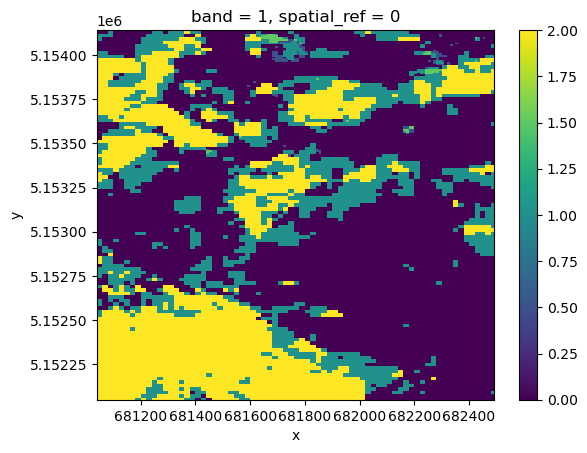

In [13]:
snowmap.plot()

## Generate STAC Item

An introduction to data sharing using the SpatioTemporal Assets Catalog (STAC) specification, which is now consider a defactpr


Fill in the stac configuration with the right path and properties to share, you can 
modify the example in the next code block

In [14]:
assets = [
    {"name": "SnowmapBolzano", "path": "results/snowmap3d.tif", "href": None,"role": None}
    # {"name": "Snowmap_2", "path": "results/snowmap3d_2.tif", "href": None,"role": None}
]

media_type = pystac.MediaType.COG
properties = {}
input_datetime = None
id = "snowmap_stac"

# to generate a collection, you need to specify the link
collection = "Snowmap Bolzano"
collection_url = None

In [15]:
stac_item = generate_stac(assets, media_type, id="Snow_map",
              collection=None, collection_url=None,
              input_datetime=None, properties = {})
stac_item

<Item id=Snow_map>

#### Validate and save STAC

In [16]:
stac_item.validate()

['https://schemas.stacspec.org/v1.0.0/item-spec/json-schema/item.json',
 'https://stac-extensions.github.io/projection/v1.1.0/schema.json',
 'https://stac-extensions.github.io/raster/v1.1.0/schema.json',
 'https://stac-extensions.github.io/eo/v1.1.0/schema.json']

In [17]:
print(json.dumps(stac_item.to_dict(), indent=4))

{
    "type": "Feature",
    "stac_version": "1.0.0",
    "id": "Snow_map",
    "properties": {
        "datetime": "2023-10-13T09:06:40.936320Z"
    },
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [
                    11.359317806927063,
                    46.49728887508481
                ],
                [
                    11.379017913669749,
                    46.49728887508481
                ],
                [
                    11.379017913669749,
                    46.516473153832116
                ],
                [
                    11.359317806927063,
                    46.516473153832116
                ],
                [
                    11.359317806927063,
                    46.49728887508481
                ]
            ]
        ]
    },
    "links": [],
    "assets": {
        "SnowmapBolzano": {
            "href": "results/snowmap3d.tif",
            "type": "image/tiff; application=geoti

In [18]:
stac_json = json.dumps(stac_item.to_dict())
with open("results/stac_item.json", "w") as file:
    file.write(stac_json)